In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] =15,9
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [112]:
df = pd.read_csv('sensity_events.csv')

In [3]:
df.head()

,uuid,asset_id,start_time,end_time,session_type,latitude,longitude,geometry
0,SENSITY-kc-23-40D98DC1-41F8-40EE-BBB8-E44DE41C...,SENSITY-kc-23,2018-08-10 23:33:26.081,2018-08-10 23:33:55.9371,car,39.109786,-94.583482,"{""type"":""Polygon"",""coordinates"":[[[-94.5834598..."
1,SENSITY-kc-22-E5EBBB3A-05E4-4D9C-97CB-26542918...,SENSITY-kc-22,2018-08-10 23:34:58.454,2018-08-10 23:36:08.256733,car,39.109536,-94.580771,"{""type"":""Polygon"",""coordinates"":[[[-94.5807547..."
2,SENSITY-kc-10-C4D472BA-65CA-4D2B-A6C0-9C3981CD...,SENSITY-kc-10,2018-08-10 23:33:40.424,2018-08-10 23:36:25.890125,car,39.094360,-94.583396,"{""type"":""Polygon"",""coordinates"":[[[-94.5834062..."
3,SENSITY-kc-12-4C26D1EC-4CCE-4E9A-87D1-D93149F5...,SENSITY-kc-12,2018-08-10 23:34:44.149,2018-08-10 23:38:53.829785,car,39.095302,-94.583515,"{""type"":""Polygon"",""coordinates"":[[[-94.5835249..."
4,SENSITY-kc-9-CDDB22AD-31F6-4A11-BC94-CCC6602575A1,SENSITY-kc-9,2018-08-10 23:37:38.946,2018-08-10 23:39:01.415632,car,39.092984,-94.583621,"{""type"":""Polygon"",""coordinates"":[[[-94.5836287..."


In [4]:
df.shape

(162124, 8)

In [5]:
df.dropna(axis=0,how='any',inplace=True)
df.drop(columns='geometry',inplace=True)
df.drop(columns='session_type',inplace=True)

In [6]:
df.drop(columns='uuid',inplace=True)

In [7]:
df.drop(columns='latitude',inplace=True)
df.drop(columns='longitude',inplace=True)

In [8]:
df.shape

(103943, 3)

In [9]:
df.rename(columns={'start_time':'start_date','end_time':'end_date'},inplace=True)

In [10]:
df.dtypes

asset_id      object
start_date    object
end_date      object
dtype: object

In [11]:
df['start_date'] = pd.to_datetime(df.start_date,format='%Y/%m/%d').astype('datetime64[s]')
df['end_date'] = pd.to_datetime(df.end_date,format='%Y/%m/%d').astype('datetime64[s]')

In [12]:
df.dtypes

asset_id              object
start_date    datetime64[ns]
end_date      datetime64[ns]
dtype: object

In [13]:
dist_df = df[['asset_id','start_date','end_date']].drop_duplicates()

In [14]:
dist_df.shape

(102590, 3)

In [15]:
temp = pd.to_datetime('2018-08-10',format='%Y\%m\%d')
dist_df.loc[(pd.to_datetime(dist_df.start_date.dt.date) == temp) & (
    dist_df['asset_id']=='SENSITY-kc-2')].sort_values(by=['start_date'],ascending=True)

,asset_id,start_date,end_date
7,SENSITY-kc-2,2018-08-10 23:33:24,2018-08-10 23:47:47
199,SENSITY-kc-2,2018-08-10 23:38:34,2018-08-10 23:47:47
129,SENSITY-kc-2,2018-08-10 23:47:47,2018-08-10 23:50:55
130,SENSITY-kc-2,2018-08-10 23:48:14,2018-08-10 23:50:55
202,SENSITY-kc-2,2018-08-10 23:48:14,2018-08-10 23:53:05
227,SENSITY-kc-2,2018-08-10 23:48:23,2018-08-10 23:53:05
57,SENSITY-kc-2,2018-08-10 23:50:59,2018-08-10 23:53:05
60,SENSITY-kc-2,2018-08-10 23:53:05,2018-08-11 00:01:13
134,SENSITY-kc-2,2018-08-10 23:53:06,2018-08-11 00:01:28


In [16]:
dist_df['start_from_fc']= dist_df.start_date.dt.floor('5min')
dist_df['end_from_fc'] = dist_df.end_date.dt.ceil('5min')

In [17]:
dist_df.isnull().sum()

asset_id         0
start_date       0
end_date         0
start_from_fc    0
end_from_fc      0
dtype: int64

In [18]:
dist_df.dtypes

asset_id                 object
start_date       datetime64[ns]
end_date         datetime64[ns]
start_from_fc    datetime64[ns]
end_from_fc      datetime64[ns]
dtype: object

In [19]:
dist_df.head()

,asset_id,start_date,end_date,start_from_fc,end_from_fc
0,SENSITY-kc-23,2018-08-10 23:33:26,2018-08-10 23:33:55,2018-08-10 23:30:00,2018-08-10 23:35:00
1,SENSITY-kc-22,2018-08-10 23:34:58,2018-08-10 23:36:08,2018-08-10 23:30:00,2018-08-10 23:40:00
2,SENSITY-kc-10,2018-08-10 23:33:40,2018-08-10 23:36:25,2018-08-10 23:30:00,2018-08-10 23:40:00
3,SENSITY-kc-12,2018-08-10 23:34:44,2018-08-10 23:38:53,2018-08-10 23:30:00,2018-08-10 23:40:00
4,SENSITY-kc-9,2018-08-10 23:37:38,2018-08-10 23:39:01,2018-08-10 23:35:00,2018-08-10 23:40:00


In [20]:
temp = pd.to_datetime('2018-08-10',format='%Y\%m\%d')
dist_df.loc[(pd.to_datetime(df.start_date.dt.date) == temp) & (
    dist_df['asset_id']=='SENSITY-kc-2')].sort_values(by=['start_date'],ascending=True)

,asset_id,start_date,end_date,start_from_fc,end_from_fc
7,SENSITY-kc-2,2018-08-10 23:33:24,2018-08-10 23:47:47,2018-08-10 23:30:00,2018-08-10 23:50:00
199,SENSITY-kc-2,2018-08-10 23:38:34,2018-08-10 23:47:47,2018-08-10 23:35:00,2018-08-10 23:50:00
129,SENSITY-kc-2,2018-08-10 23:47:47,2018-08-10 23:50:55,2018-08-10 23:45:00,2018-08-10 23:55:00
130,SENSITY-kc-2,2018-08-10 23:48:14,2018-08-10 23:50:55,2018-08-10 23:45:00,2018-08-10 23:55:00
202,SENSITY-kc-2,2018-08-10 23:48:14,2018-08-10 23:53:05,2018-08-10 23:45:00,2018-08-10 23:55:00
227,SENSITY-kc-2,2018-08-10 23:48:23,2018-08-10 23:53:05,2018-08-10 23:45:00,2018-08-10 23:55:00
57,SENSITY-kc-2,2018-08-10 23:50:59,2018-08-10 23:53:05,2018-08-10 23:50:00,2018-08-10 23:55:00
60,SENSITY-kc-2,2018-08-10 23:53:05,2018-08-11 00:01:13,2018-08-10 23:50:00,2018-08-11 00:05:00
134,SENSITY-kc-2,2018-08-10 23:53:06,2018-08-11 00:01:28,2018-08-10 23:50:00,2018-08-11 00:05:00


In [21]:
n = (dist_df.end_from_fc - dist_df.start_from_fc)
# n,(n.dt.total_seconds())/60
dist_df['diff'] = (n.dt.total_seconds())/60

In [22]:
dist_df.head(50)

,asset_id,start_date,end_date,start_from_fc,end_from_fc,diff
0,SENSITY-kc-23,2018-08-10 23:33:26,2018-08-10 23:33:55,2018-08-10 23:30:00,2018-08-10 23:35:00,5.0
1,SENSITY-kc-22,2018-08-10 23:34:58,2018-08-10 23:36:08,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0
2,SENSITY-kc-10,2018-08-10 23:33:40,2018-08-10 23:36:25,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0
3,SENSITY-kc-12,2018-08-10 23:34:44,2018-08-10 23:38:53,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0
4,SENSITY-kc-9,2018-08-10 23:37:38,2018-08-10 23:39:01,2018-08-10 23:35:00,2018-08-10 23:40:00,5.0
5,SENSITY-kc-14,2018-08-10 23:34:12,2018-08-10 23:39:38,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0
6,SENSITY-kc-18,2018-08-10 23:36:28,2018-08-10 23:40:19,2018-08-10 23:35:00,2018-08-10 23:45:00,10.0
7,SENSITY-kc-2,2018-08-10 23:33:24,2018-08-10 23:47:47,2018-08-10 23:30:00,2018-08-10 23:50:00,20.0
8,SENSITY-kc-12,2018-08-10 23:47:25,2018-08-10 23:47:50,2018-08-10 23:45:00,2018-08-10 23:50:00,5.0
9,SENSITY-kc-21,2018-08-10 23:47:51,2018-08-10 23:49:26,2018-08-10 23:45:00,2018-08-10 23:50:00,5.0


In [23]:
dist_df[dist_df['diff'].isnull()]

,asset_id,start_date,end_date,start_from_fc,end_from_fc,diff


In [24]:
dist_df['slots'] = dist_df['diff']/5
dist_df['slots']=dist_df['slots'].astype('int64')
dist_df['bins'] = dist_df.slots.map( lambda x: np.arange(1,x+1,1) if x > 1.0 else np.arange(1,x+1))

In [25]:
dist_df.head()

,asset_id,start_date,end_date,start_from_fc,end_from_fc,diff,slots,bins
0,SENSITY-kc-23,2018-08-10 23:33:26,2018-08-10 23:33:55,2018-08-10 23:30:00,2018-08-10 23:35:00,5.0,1,[1]
1,SENSITY-kc-22,2018-08-10 23:34:58,2018-08-10 23:36:08,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,"[1, 2]"
2,SENSITY-kc-10,2018-08-10 23:33:40,2018-08-10 23:36:25,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,"[1, 2]"
3,SENSITY-kc-12,2018-08-10 23:34:44,2018-08-10 23:38:53,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,"[1, 2]"
4,SENSITY-kc-9,2018-08-10 23:37:38,2018-08-10 23:39:01,2018-08-10 23:35:00,2018-08-10 23:40:00,5.0,1,[1]


In [26]:
dist_df.dtypes

asset_id                 object
start_date       datetime64[ns]
end_date         datetime64[ns]
start_from_fc    datetime64[ns]
end_from_fc      datetime64[ns]
diff                    float64
slots                     int64
bins                     object
dtype: object

In [27]:
dist_df['start'] = dist_df.start_date.dt.date
dist_df['start'] = pd.to_datetime(dist_df.start,format='%Y\%m\%d')

In [28]:
dist_df.head(5)

,asset_id,start_date,end_date,start_from_fc,end_from_fc,diff,slots,bins,start
0,SENSITY-kc-23,2018-08-10 23:33:26,2018-08-10 23:33:55,2018-08-10 23:30:00,2018-08-10 23:35:00,5.0,1,[1],2018-08-10
1,SENSITY-kc-22,2018-08-10 23:34:58,2018-08-10 23:36:08,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,"[1, 2]",2018-08-10
2,SENSITY-kc-10,2018-08-10 23:33:40,2018-08-10 23:36:25,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,"[1, 2]",2018-08-10
3,SENSITY-kc-12,2018-08-10 23:34:44,2018-08-10 23:38:53,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,"[1, 2]",2018-08-10
4,SENSITY-kc-9,2018-08-10 23:37:38,2018-08-10 23:39:01,2018-08-10 23:35:00,2018-08-10 23:40:00,5.0,1,[1],2018-08-10


In [29]:
def explode(df, lst_cols, fill_value=''):
    if lst_cols and not isinstance(lst_cols, list):
        lst_cols = [lst_cols]
    idx_cols = df.columns.difference(lst_cols)
    lens = df[lst_cols[0]].str.len()
    if (lens > 0).all():
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .loc[:, df.columns]
    else:
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .append(df.loc[lens==0, idx_cols]).fillna(fill_value) \
          .loc[:, df.columns]

In [30]:
new_df=explode(dist_df, ['bins'], fill_value='')

In [31]:
new_df.isnull().sum()

asset_id         0
start_date       0
end_date         0
start_from_fc    0
end_from_fc      0
diff             0
slots            0
bins             0
start            0
dtype: int64

In [32]:
new_df[new_df['slots'].isnull()]

,asset_id,start_date,end_date,start_from_fc,end_from_fc,diff,slots,bins,start


In [33]:
new_df['bins'] = (new_df.start_from_fc + pd.to_timedelta(5*(new_df['bins']), unit='m'))
new_df['bins1'] = new_df.bins - pd.to_timedelta(5, unit='m')

In [34]:
new_df.head(100)

,asset_id,start_date,end_date,start_from_fc,end_from_fc,diff,slots,bins,start,bins1
0,SENSITY-kc-23,2018-08-10 23:33:26,2018-08-10 23:33:55,2018-08-10 23:30:00,2018-08-10 23:35:00,5.0,1,2018-08-10 23:35:00,2018-08-10,2018-08-10 23:30:00
1,SENSITY-kc-22,2018-08-10 23:34:58,2018-08-10 23:36:08,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,2018-08-10 23:35:00,2018-08-10,2018-08-10 23:30:00
2,SENSITY-kc-22,2018-08-10 23:34:58,2018-08-10 23:36:08,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,2018-08-10 23:40:00,2018-08-10,2018-08-10 23:35:00
3,SENSITY-kc-10,2018-08-10 23:33:40,2018-08-10 23:36:25,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,2018-08-10 23:35:00,2018-08-10,2018-08-10 23:30:00
4,SENSITY-kc-10,2018-08-10 23:33:40,2018-08-10 23:36:25,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,2018-08-10 23:40:00,2018-08-10,2018-08-10 23:35:00
5,SENSITY-kc-12,2018-08-10 23:34:44,2018-08-10 23:38:53,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,2018-08-10 23:35:00,2018-08-10,2018-08-10 23:30:00
6,SENSITY-kc-12,2018-08-10 23:34:44,2018-08-10 23:38:53,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,2018-08-10 23:40:00,2018-08-10,2018-08-10 23:35:00
7,SENSITY-kc-9,2018-08-10 23:37:38,2018-08-10 23:39:01,2018-08-10 23:35:00,2018-08-10 23:40:00,5.0,1,2018-08-10 23:40:00,2018-08-10,2018-08-10 23:35:00
8,SENSITY-kc-14,2018-08-10 23:34:12,2018-08-10 23:39:38,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,2018-08-10 23:35:00,2018-08-10,2018-08-10 23:30:00
9,SENSITY-kc-14,2018-08-10 23:34:12,2018-08-10 23:39:38,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,2018-08-10 23:40:00,2018-08-10,2018-08-10 23:35:00


In [35]:
 new_df.groupby(['bins1','bins','asset_id']).count()[['start_from_fc']]

start_from_fc
bins1               bins                asset_id                    
2018-08-10 23:30:00 2018-08-10 23:35:00 SENSITY-kc-10              2
                                        SENSITY-kc-12              4
                                        SENSITY-kc-14              2
                                        SENSITY-kc-18              3
                                        SENSITY-kc-2               1
                                        SENSITY-kc-22              1
                                        SENSITY-kc-23              2
                                        SENSITY-kc-8               2
2018-08-10 23:35:00 2018-08-10 23:40:00 SENSITY-kc-10              4
                                        SENSITY-kc-12              4
                                        SENSITY-kc-14              5
                                        SENSITY-kc-18              5
                                        SENSITY-kc-2               2
                                        SENSITY-kc-22              2
                                        SENSITY-kc-5               5
                                        SENSITY-kc-8               2
                                        SENSITY-kc-9               2
2018-08-10 23:40:00 2018-08-10 23:45:00 SENSITY-kc-10              2
                                        SENSITY-kc-12              2
                                        SENSITY-kc-14              4
                                        SENSITY-kc-18              2
                                        SENSITY-kc-2               2
                                        SENSITY-kc-22              1
                                        SENSITY-kc-5               5
                                        SENSITY-kc-8               2
2018-08-10 23:45:00 2018-08-10 23:50:00 SENSITY-kc-10              3
                                        SENSITY-kc-12              2
                                        SENSITY-kc-14              8
                                        SENSITY-kc-2               6
                                        SENSITY-kc-21              4
...                                                              ...
2018-11-26 15:35:00 2018-11-26 15:40:00 SENSITY-kc-11              1
                                        SENSITY-kc-12              2
                                        SENSITY-kc-14              3
                                        SENSITY-kc-15              1
                                        SENSITY-kc-17              1
                                        SENSITY-kc-2               2
                                        SENSITY-kc-23              1
                                        SENSITY-kc-6               3
                                        SENSITY-kc-9               1
2018-11-26 15:40:00 2018-11-26 15:45:00 SENSITY-kc-11              1
                                        SENSITY-kc-12              1
                                        SENSITY-kc-14              2
                                        SENSITY-kc-15              1
                                        SENSITY-kc-2               1
                                        SENSITY-kc-6               2
2018-11-26 15:45:00 2018-11-26 15:50:00 SENSITY-kc-12              1
                                        SENSITY-kc-15              1
                                        SENSITY-kc-2               1
                                        SENSITY-kc-5               1
                                        SENSITY-kc-6               3
                                        SENSITY-kc-9               1
2018-11-26 15:50:00 2018-11-26 15:55:00 SENSITY-kc-10              2
                                        SENSITY-kc-11              1
                                        SENSITY-kc-12              1
                                        SENSITY-kc-5               1
                                        SENSITY-kc-6 

In [36]:
df_5min = new_df.groupby(['bins1','bins','asset_id']).count()[['start_from_fc']].add_suffix('_Count').reset_index()

In [37]:
df_5min

,bins1,bins,asset_id,start_from_fc_Count
0,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-10,2
1,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-12,4
2,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-14,2
3,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-18,3
4,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-2,1
5,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-22,1
6,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-23,2
7,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-8,2
8,2018-08-10 23:35:00,2018-08-10 23:40:00,SENSITY-kc-10,4
9,2018-08-10 23:35:00,2018-08-10 23:40:00,SENSITY-kc-12,4


In [38]:
df_5min.rename(columns={'bins1':'start_time','bins':'end_time','asset_id':'sensor_id'
                        ,'start_from_fc_Count':'no_of_cars'}
               ,inplace=True)

In [39]:
df_5min.head()

,start_time,end_time,sensor_id,no_of_cars
0,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-10,2
1,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-12,4
2,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-14,2
3,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-18,3
4,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-2,1


In [40]:
df_5min.groupby(['sensor_id']).sum()[['no_of_cars']]

,no_of_cars
sensor_id,
SENSITY-kc-1,49870
SENSITY-kc-10,97498
SENSITY-kc-11,72353
SENSITY-kc-12,100965
SENSITY-kc-14,323788
SENSITY-kc-15,182931
SENSITY-kc-17,45848
SENSITY-kc-18,92922
SENSITY-kc-19,23925


In [41]:
df_5min.shape

(350006, 4)

In [42]:
temp = pd.to_datetime('2018-09-05 07:00:00',format='%Y\%m\%d')
df_5min.loc[(df_5min['start_time'] == temp) & (
    df_5min['sensor_id']=='SENSITY-kc-1')].sort_values(by=['start_time'],ascending=True)

,start_time,end_time,sensor_id,no_of_cars


In [43]:
df_tst_5min = df_5min.loc[(df_5min['sensor_id']=='SENSITY-kc-12') & (df_5min.start_time.dt.time.astype(str) 
                                                                  > '00:00:00') & (df_5min.start_time.dt.time.astype
                                                                                   (str) 
                                                                  < '13:00:00') &
                       (df_5min.start_time.dt.date.astype(str) 
                                                                  < '2018-09-10')
                      ]

In [44]:
df_tst_5min.count()

start_time    2995
end_time      2995
sensor_id     2995
no_of_cars    2995
dtype: int64

In [45]:
df_tst_5min.groupby([df_tst_5min.start_time.dt.date])\
.count()[['start_time']]

,start_time
start_time,
2018-08-11,129
2018-08-12,88
2018-08-13,147
2018-08-14,144
2018-08-15,62
2018-08-16,90
2018-08-17,87
2018-08-18,54
2018-08-19,155


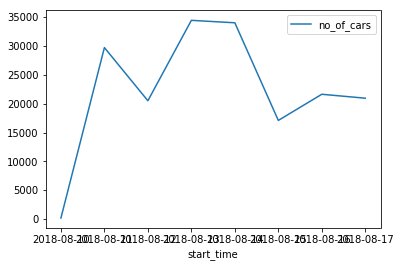

In [46]:
df_5min.loc[
                       (df_5min.start_time.dt.date.astype(str) 
                                                                  <= '2018-08-17')
                      ].groupby([df_5min.start_time.dt.date])\
.sum()[['no_of_cars']].plot()

In [47]:
df_sensor_data = df_5min.loc[(df_5min.start_time.dt.time.astype(str) 
                                                                  > '00:00:00') & (df_5min.start_time.dt.time.astype
                                                                                   (str) 
                                                                  < '13:00:00') &
                       (df_5min.start_time.dt.date.astype(str) 
                                                                  <= '2018-08-25')
                      ].groupby([df_5min['sensor_id']]).sum()[['no_of_cars']]\
.sort_values(by=['no_of_cars']).add_suffix('_Count').reset_index()

In [48]:
df_sensor_data

,sensor_id,no_of_cars_Count
0,SENSITY-kc-19,305
1,SENSITY-kc-1,2027
2,SENSITY-kc-21,2382
3,SENSITY-kc-22,2499
4,SENSITY-kc-17,2843
5,SENSITY-kc-7,3028
6,SENSITY-kc-4,3639
7,SENSITY-kc-6,4967
8,SENSITY-kc-11,5650
9,SENSITY-kc-12,7065


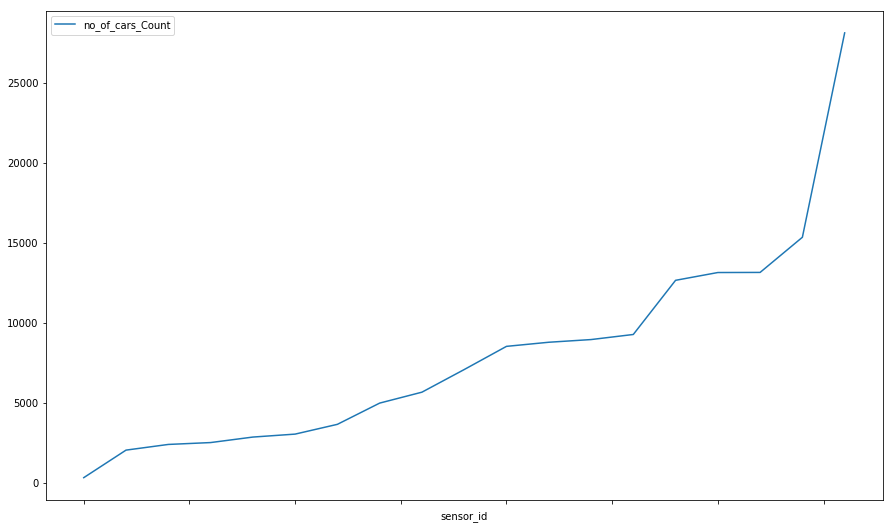

In [49]:
df_sensor_data.set_index('sensor_id').plot(figsize=(15, 9))

In [50]:
df_all_sensors_1stweek = df_5min.groupby(['sensor_id',df_5min.start_time.dt.dayofweek])\
.sum()[['no_of_cars']].add_suffix('_Count').reset_index()

In [51]:
# df_5min['day_of_the_week'] = df_5min.start_time.dt.dayofweek
df_all_sensors_1stweek

,sensor_id,start_time,no_of_cars_Count
0,SENSITY-kc-1,0,3067
1,SENSITY-kc-1,1,6124
2,SENSITY-kc-1,2,8128
3,SENSITY-kc-1,3,6480
4,SENSITY-kc-1,4,5467
5,SENSITY-kc-1,5,8569
6,SENSITY-kc-1,6,12035
7,SENSITY-kc-10,0,9097
8,SENSITY-kc-10,1,10512
9,SENSITY-kc-10,2,16672


In [52]:
df_pivot_sen = df_all_sensors_1stweek.pivot(index='start_time', columns='sensor_id', values='no_of_cars_Count')

In [53]:
df_pivot_sen.fillna(0,inplace=True)

In [54]:
df_pivot_sen

sensor_id,SENSITY-kc-1,SENSITY-kc-10,SENSITY-kc-11,SENSITY-kc-12,SENSITY-kc-14,SENSITY-kc-15,SENSITY-kc-17,SENSITY-kc-18,SENSITY-kc-19,SENSITY-kc-2,SENSITY-kc-21,SENSITY-kc-22,SENSITY-kc-23,SENSITY-kc-4,SENSITY-kc-5,SENSITY-kc-6,SENSITY-kc-7,SENSITY-kc-8,SENSITY-kc-9
start_time,,,,,,,,,,,,,,,,,,,
0,3067,9097,8112,15093,34696,21011,6434,13556,2575,17259,4673,6461,13789,6015,16721,9299,4908,16752,13399
1,6124,10512,8277,14318,40177,22909,9208,10279,3139,21601,6127,5325,17729,7917,23495,11907,5813,18510,13686
2,8128,16672,10469,10061,49083,25884,7667,10968,2152,25797,5047,5208,16063,6291,20701,12071,5124,17024,15884
3,6480,18086,9557,12887,46315,27341,7362,12310,1899,23727,7251,6809,18380,5164,20828,13645,7198,18112,15536
4,5467,10800,8012,13059,37813,22331,7530,11027,2734,23164,5868,7789,17610,5520,28686,14724,5450,19417,14710
5,8569,17240,15906,20169,57369,37654,4151,20308,5521,33093,12350,16330,25054,6290,39567,12055,6687,25342,21562
6,12035,15091,12020,15378,58335,25801,3496,14474,5905,33841,11019,12109,23775,6382,32202,10226,4707,22542,18819


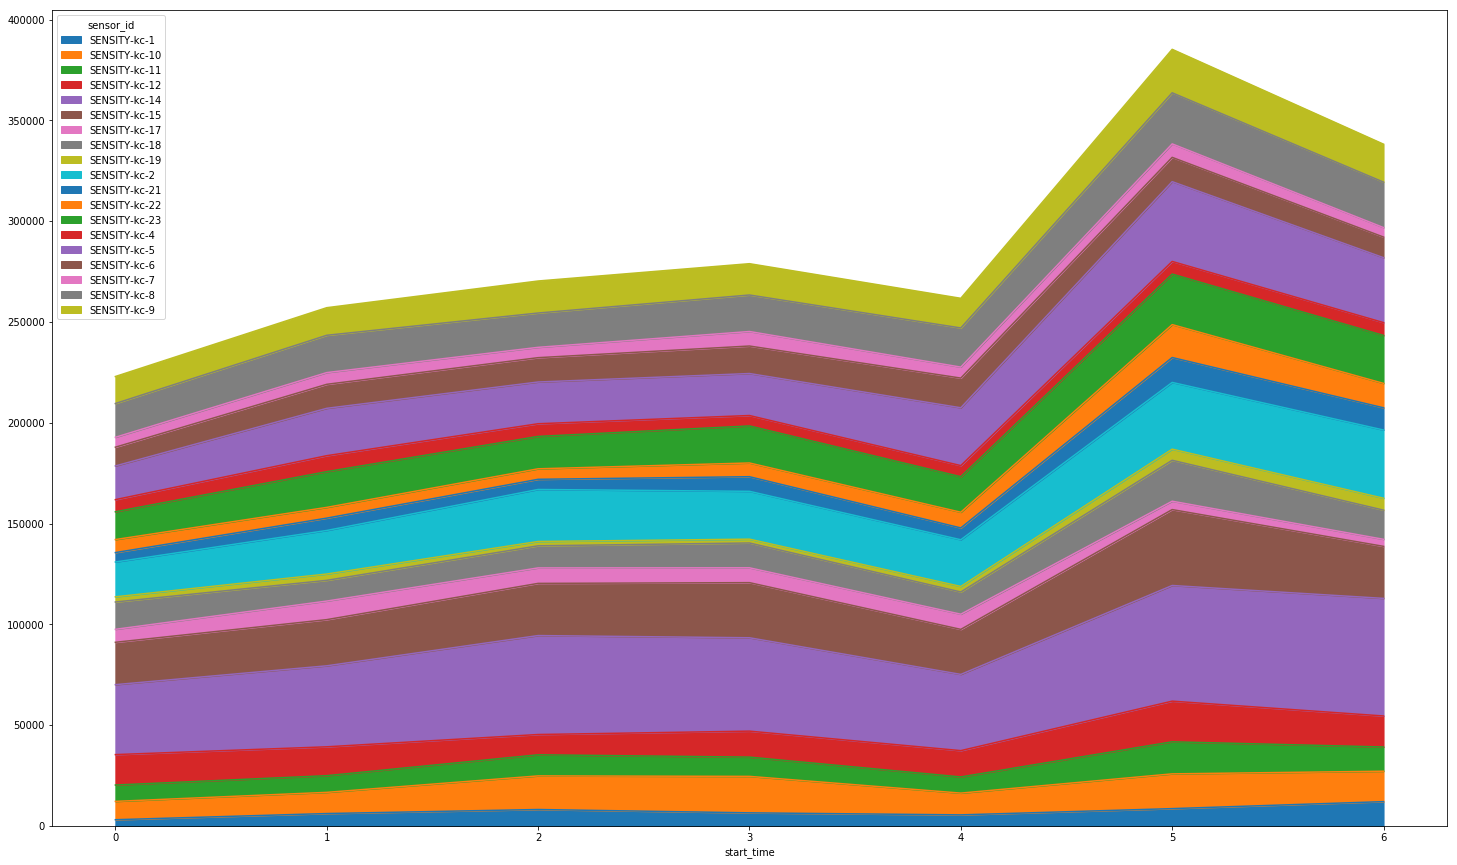

In [55]:
df_pivot_sen.plot(kind='area', 
#              stacked=False,
             figsize=(25, 15), # pass a tuple (x, y) size
             )

In [56]:
df_sensor_1stsensor = df_5min.loc[
                       (df_5min['sensor_id']=='SENSITY-kc-1')
                      ].groupby(['sensor_id',df_5min.start_time.dt.dayofweek])\
.sum()[['no_of_cars']].add_suffix('_Count').reset_index()

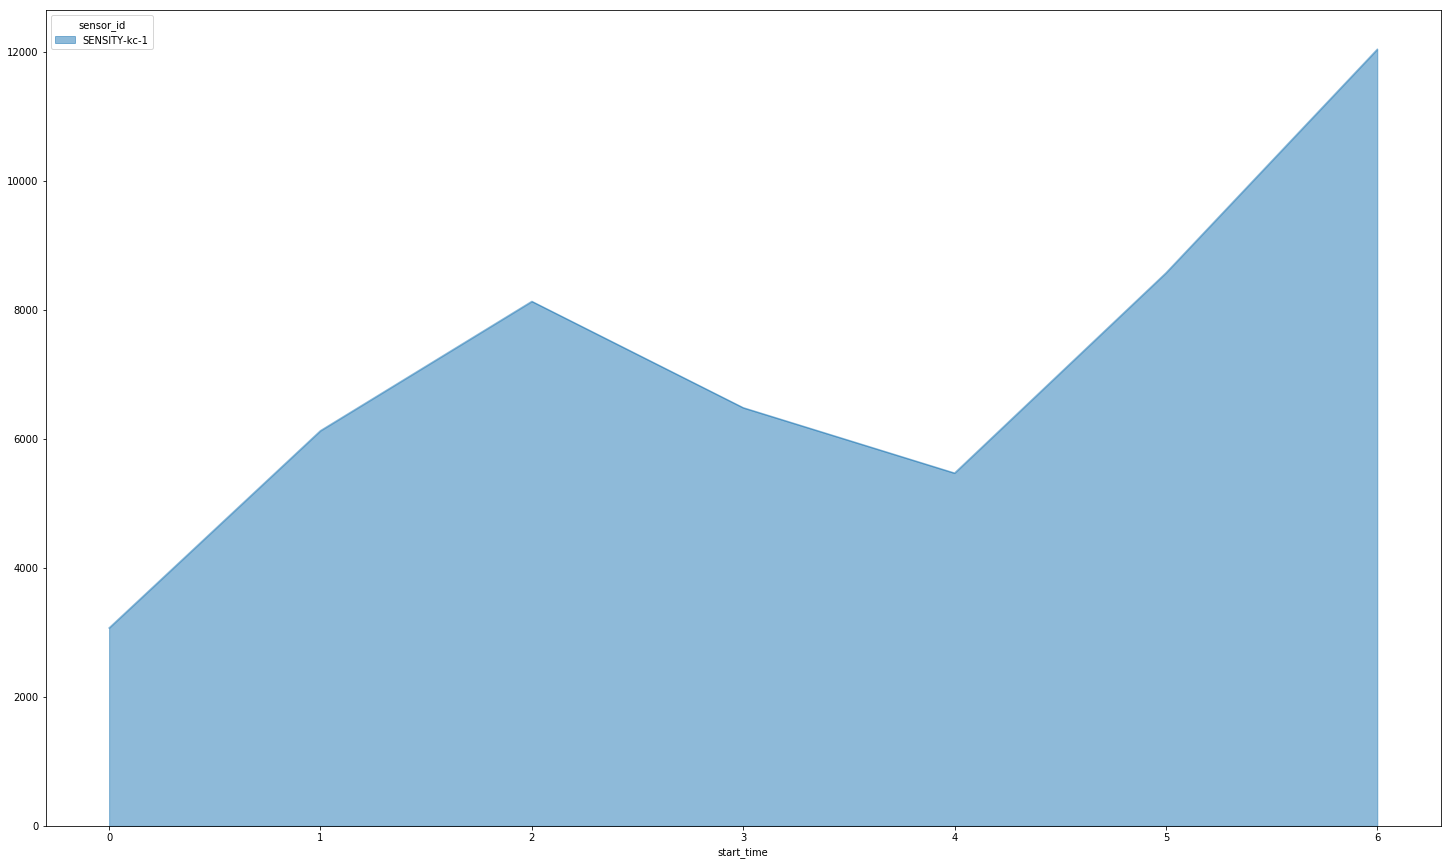

In [57]:
df_pivot_sen_1stsensor = df_sensor_1stsensor.pivot(index='start_time', columns='sensor_id', values='no_of_cars_Count')
df_pivot_sen_1stsensor.fillna(0,inplace=True)
df_pivot_sen_1stsensor.plot(kind='area', 
             stacked=False,
             figsize=(25, 15), # pass a tuple (x, y) size
             )

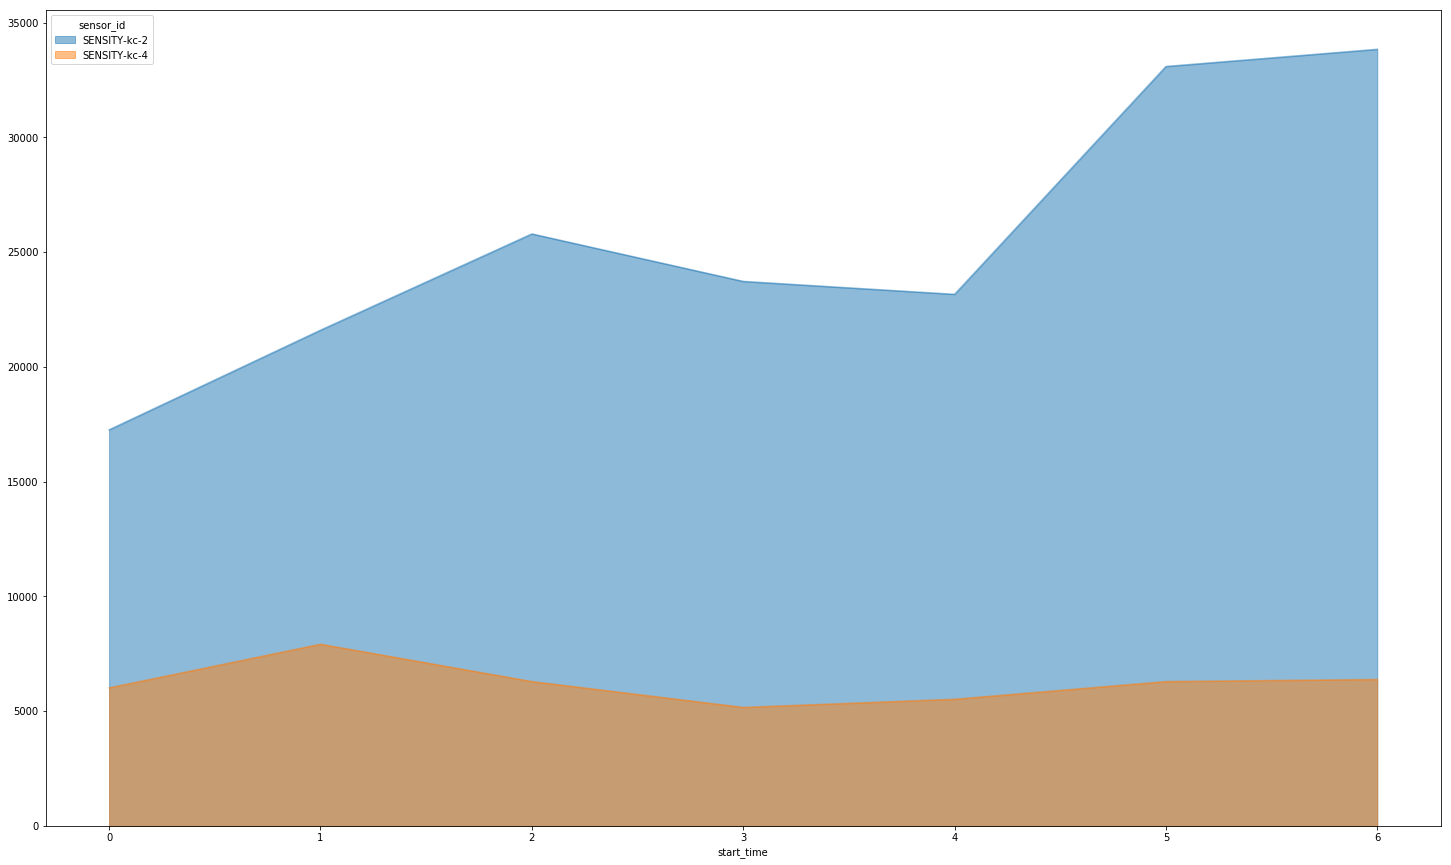

In [58]:
df_sensors_3n4sensor = df_5min.loc[
                       (df_5min['sensor_id'].isin(['SENSITY-kc-2','SENSITY-kc-4']))
                      ].groupby(['sensor_id',df_5min.start_time.dt.dayofweek])\
.sum()[['no_of_cars']].add_suffix('_Count').reset_index()
df_pivot_sen_3n4sensor = df_sensors_3n4sensor.pivot(index='start_time', columns='sensor_id', values='no_of_cars_Count')
df_pivot_sen_3n4sensor.fillna(0,inplace=True)
df_pivot_sen_3n4sensor.plot(kind='area', 
             stacked=False,
             figsize=(25, 15), # pass a tuple (x, y) size
             )

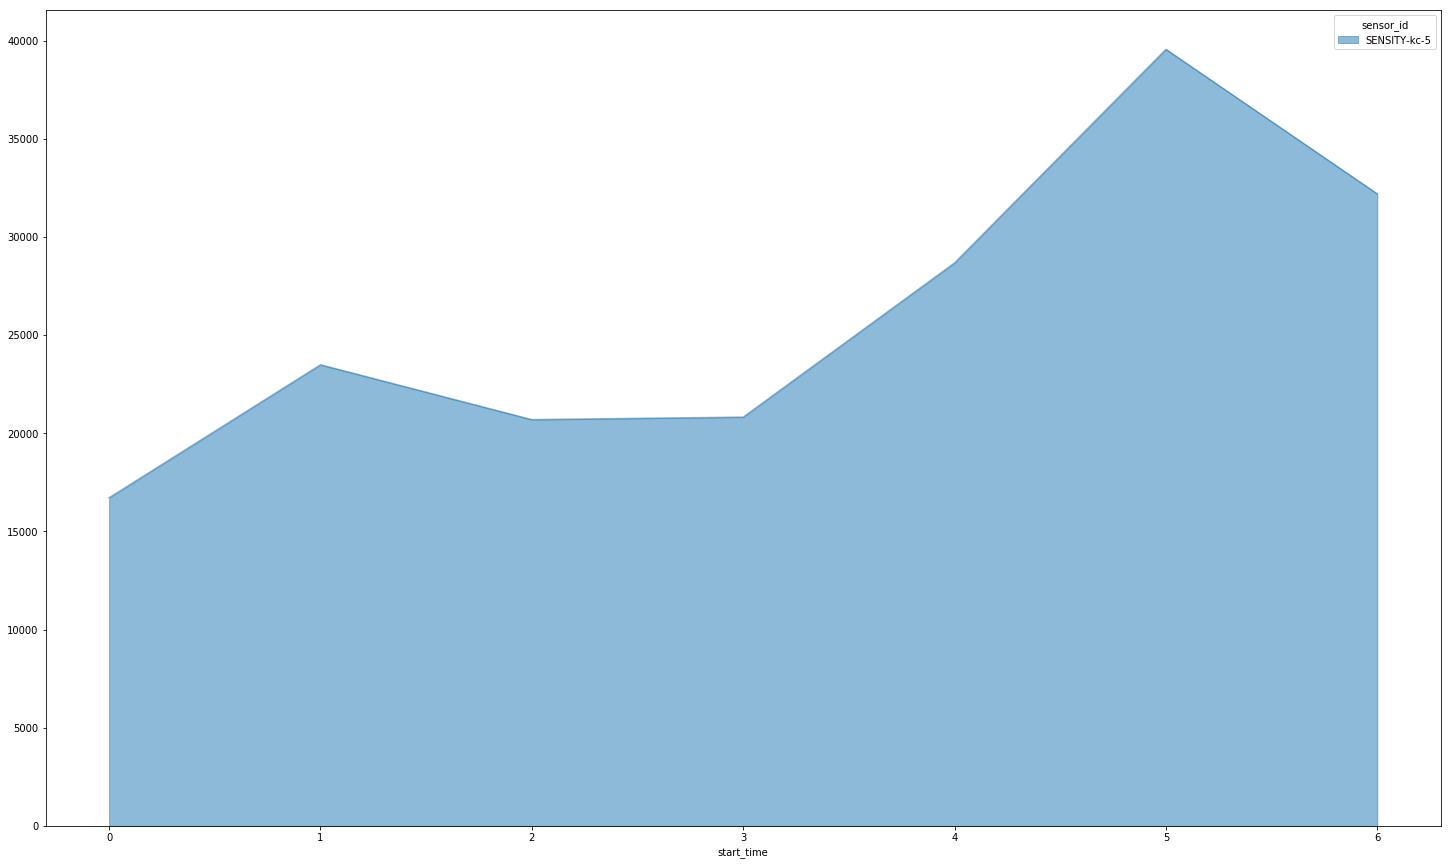

In [59]:
df_sensors_5sensor = df_5min.loc[
                       (df_5min['sensor_id'].isin(['SENSITY-kc-5']))
                      ].groupby(['sensor_id',df_5min.start_time.dt.dayofweek])\
.sum()[['no_of_cars']].add_suffix('_Count').reset_index()
df_pivot_sen_5sensor = df_sensors_5sensor.pivot(index='start_time', columns='sensor_id', values='no_of_cars_Count')
df_pivot_sen_5sensor.fillna(0,inplace=True)
df_pivot_sen_5sensor.plot(kind='area', 
             stacked=False,
             figsize=(25, 15), # pass a tuple (x, y) size
             )

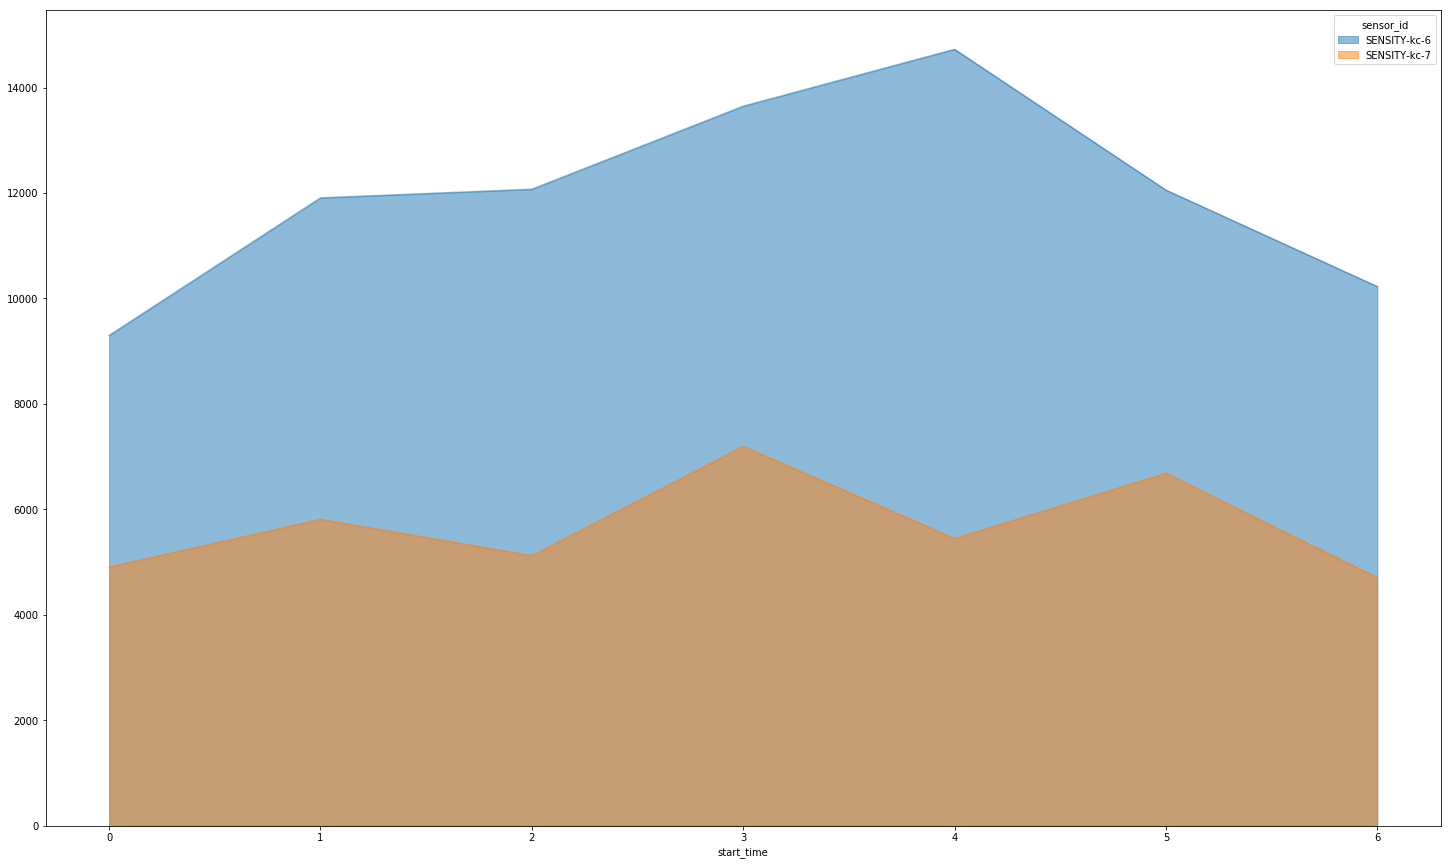

In [60]:
df_sensors_6n7sensor = df_5min.loc[
                       (df_5min['sensor_id'].isin(['SENSITY-kc-6','SENSITY-kc-7']))
                      ].groupby(['sensor_id',df_5min.start_time.dt.dayofweek])\
.sum()[['no_of_cars']].add_suffix('_Count').reset_index()
df_pivot_sen_6n7sensor = df_sensors_6n7sensor.pivot(index='start_time', columns='sensor_id', values='no_of_cars_Count')
df_pivot_sen_6n7sensor.fillna(0,inplace=True)
df_pivot_sen_6n7sensor.plot(kind='area', 
             stacked=False,
             figsize=(25, 15), # pass a tuple (x, y) size
             )

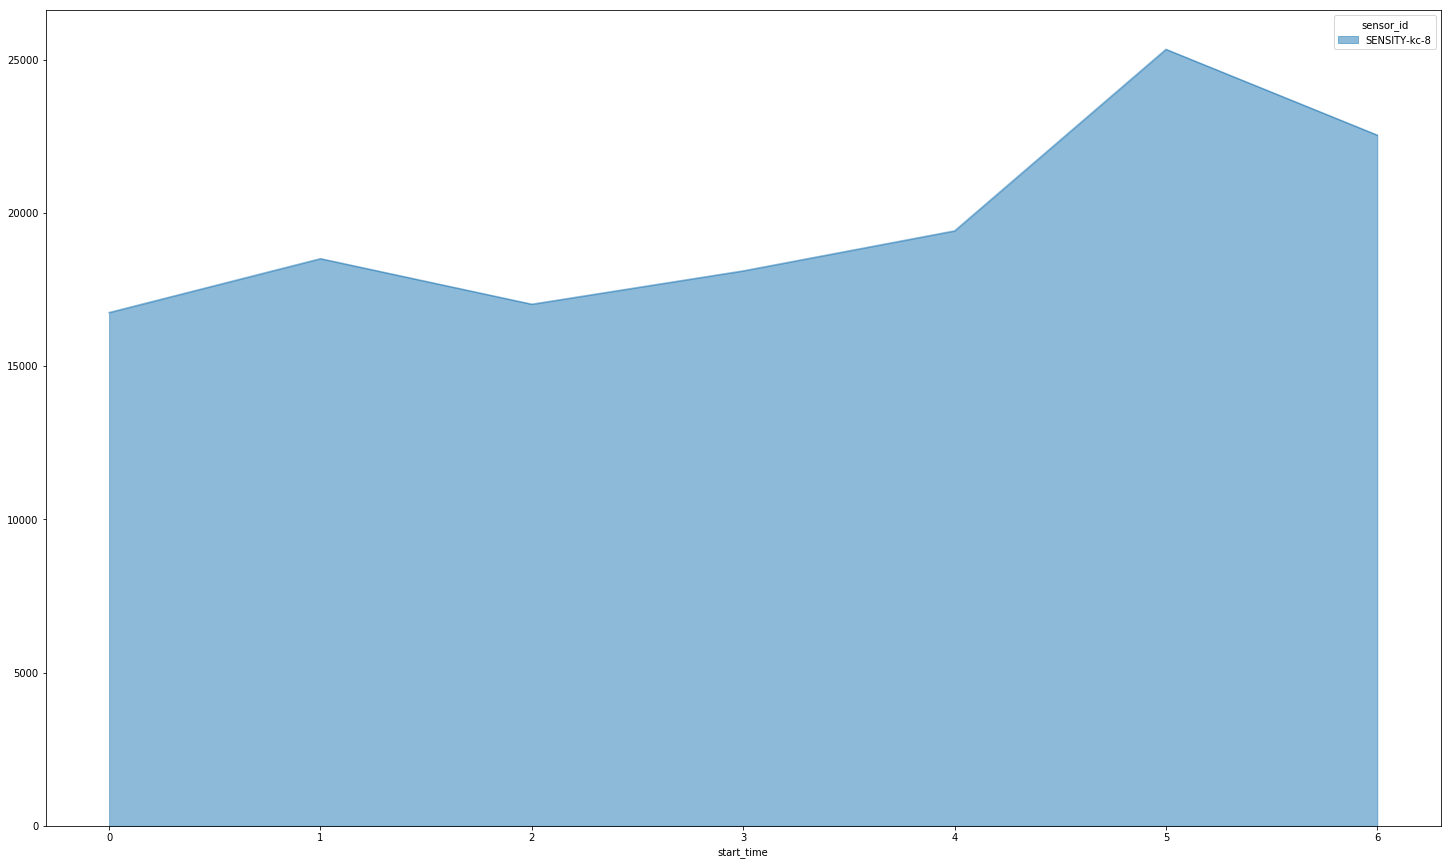

In [61]:
df_sensors_8sensor = df_5min.loc[
                       (df_5min['sensor_id'].isin(['SENSITY-kc-8']))
                      ].groupby(['sensor_id',df_5min.start_time.dt.dayofweek])\
.sum()[['no_of_cars']].add_suffix('_Count').reset_index()
df_pivot_sen_8sensor = df_sensors_8sensor.pivot(index='start_time', columns='sensor_id', values='no_of_cars_Count')
df_pivot_sen_8sensor.fillna(0,inplace=True)
df_pivot_sen_8sensor.plot(kind='area', 
             stacked=False,
             figsize=(25, 15), # pass a tuple (x, y) size
             )

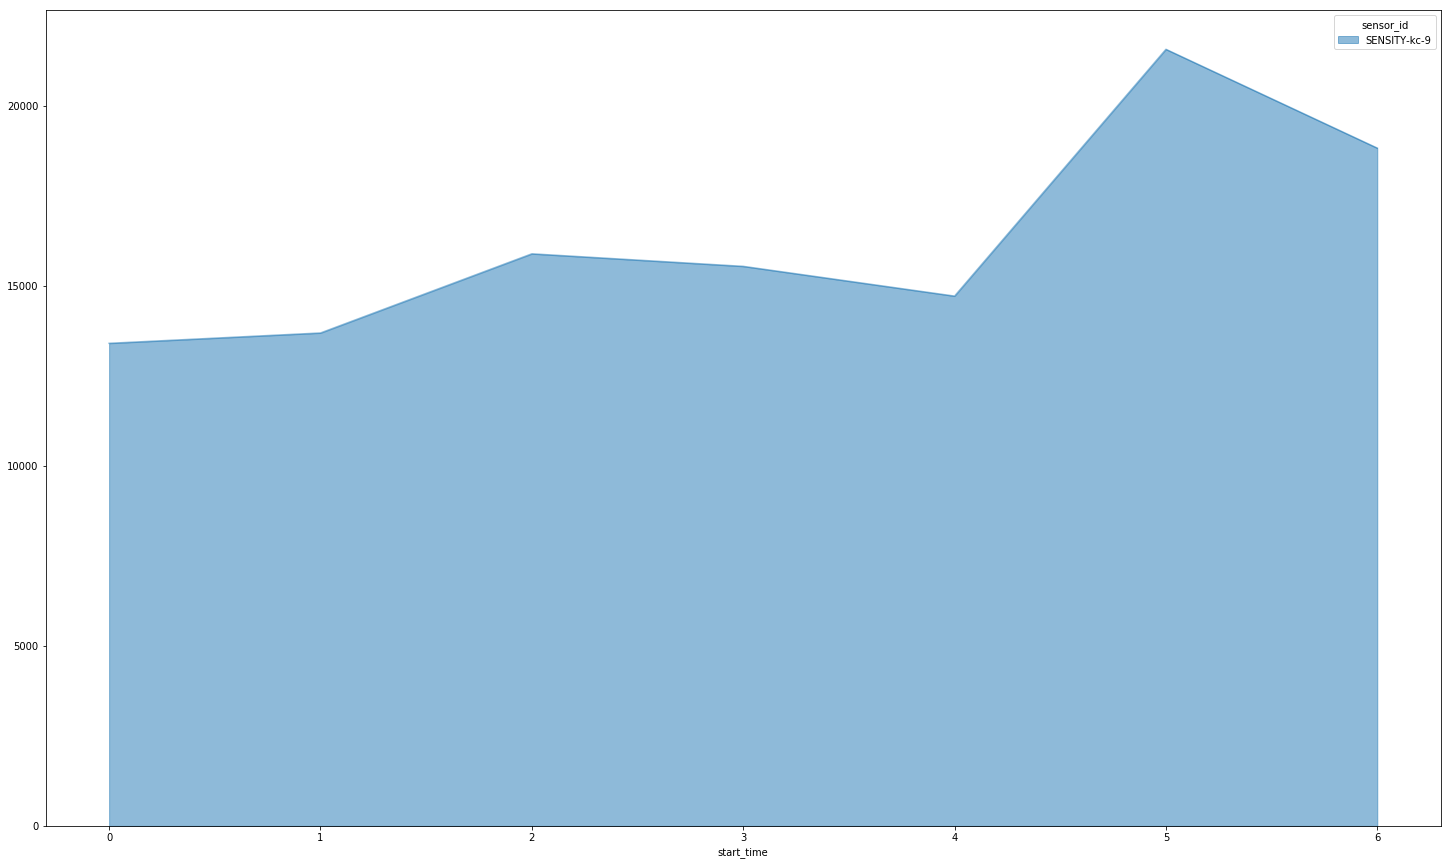

In [62]:
df_sensors_9sensor = df_5min.loc[
                       (df_5min['sensor_id'].isin(['SENSITY-kc-9']))
                      ].groupby(['sensor_id',df_5min.start_time.dt.dayofweek])\
.sum()[['no_of_cars']].add_suffix('_Count').reset_index()
df_pivot_sen_9sensor = df_sensors_9sensor.pivot(index='start_time', columns='sensor_id', values='no_of_cars_Count')
df_pivot_sen_9sensor.fillna(0,inplace=True)
df_pivot_sen_9sensor.plot(kind='area', 
             stacked=False,
             figsize=(25, 15), # pass a tuple (x, y) size
             )

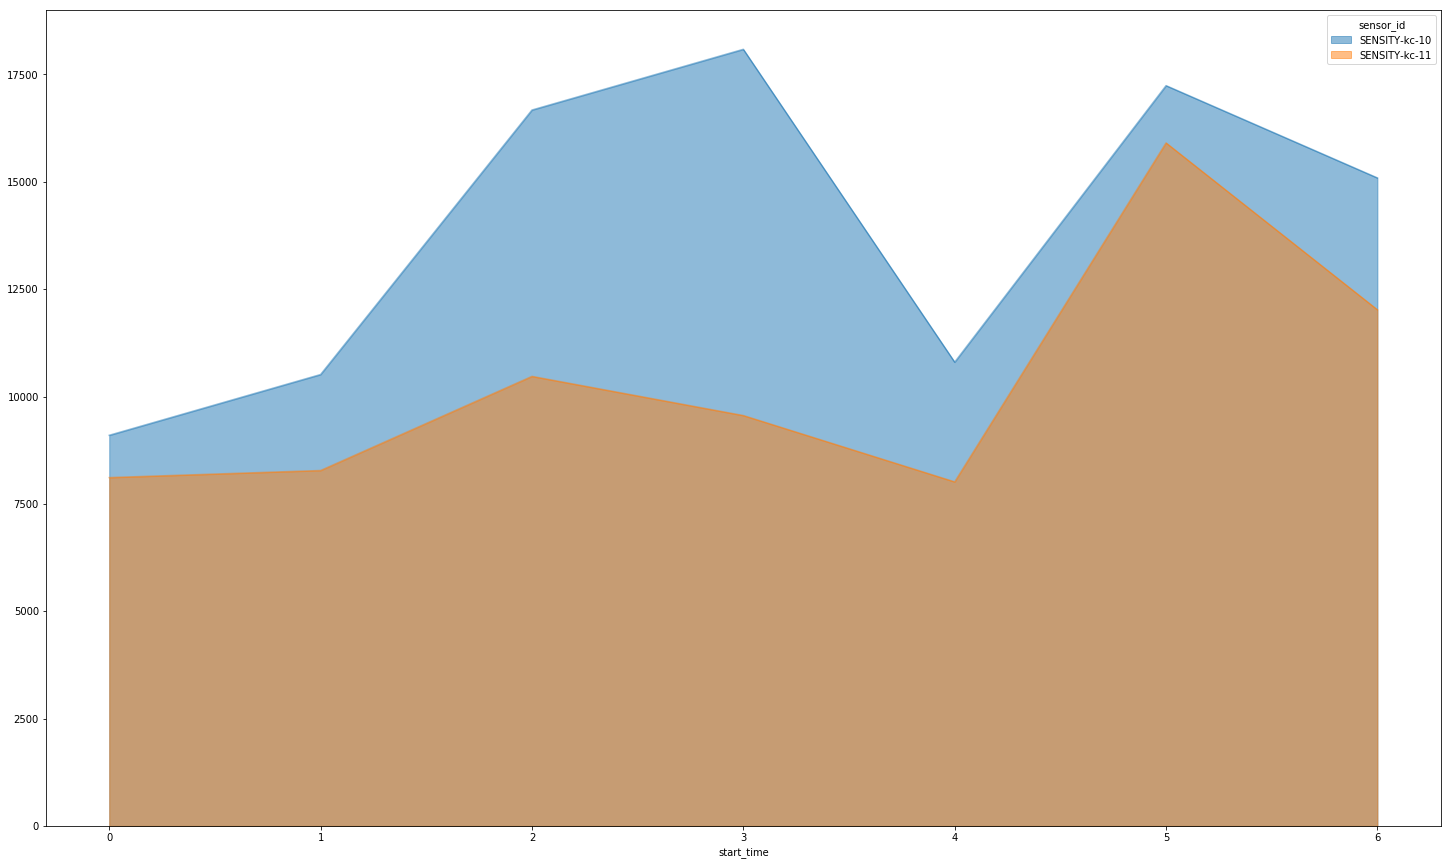

In [63]:
df_sensors_10n11sensor = df_5min.loc[
                       (df_5min['sensor_id'].isin(['SENSITY-kc-10','SENSITY-kc-11']))
                      ].groupby(['sensor_id',df_5min.start_time.dt.dayofweek])\
.sum()[['no_of_cars']].add_suffix('_Count').reset_index()
df_pivot_sen_10n11sensor = df_sensors_10n11sensor.pivot(index='start_time', columns='sensor_id', values='no_of_cars_Count')
df_pivot_sen_10n11sensor.fillna(0,inplace=True)
df_pivot_sen_10n11sensor.plot(kind='area', 
             stacked=False,
             figsize=(25, 15), # pass a tuple (x, y) size
             )

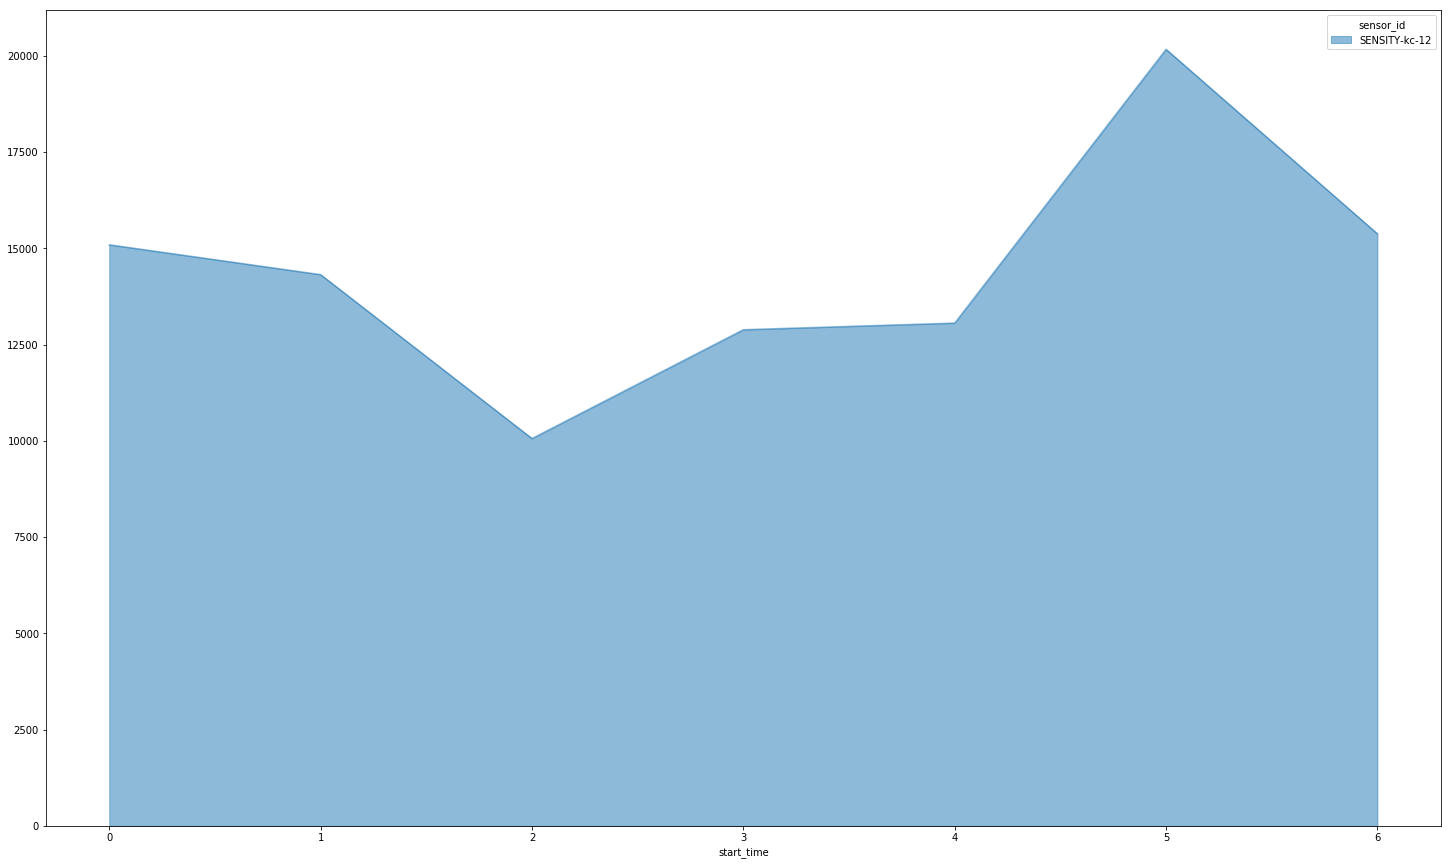

In [64]:
df_sensors_12sensor = df_5min.loc[
                       (df_5min['sensor_id'].isin(['SENSITY-kc-12']))
                      ].groupby(['sensor_id',df_5min.start_time.dt.dayofweek])\
.sum()[['no_of_cars']].add_suffix('_Count').reset_index()
df_pivot_sen_12sensor = df_sensors_12sensor.pivot(index='start_time', columns='sensor_id', values='no_of_cars_Count')
df_pivot_sen_12sensor.fillna(0,inplace=True)
df_pivot_sen_12sensor.plot(kind='area', 
             stacked=False,
             figsize=(25, 15),
             )

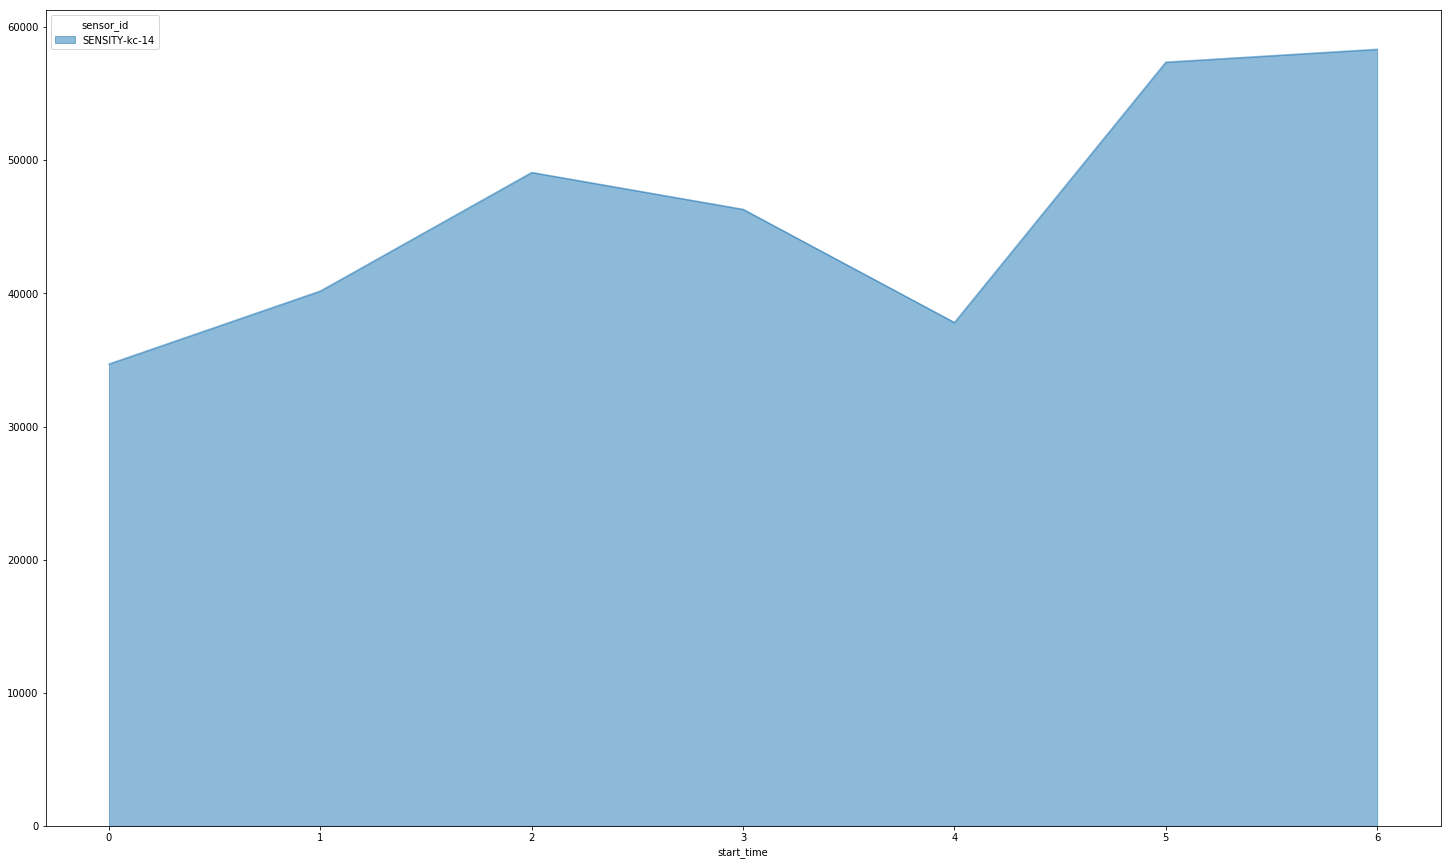

In [65]:
df_sensors_14sensor = df_5min.loc[
                       (df_5min['sensor_id'].isin(['SENSITY-kc-14']))
                      ].groupby(['sensor_id',df_5min.start_time.dt.dayofweek])\
.sum()[['no_of_cars']].add_suffix('_Count').reset_index()
df_pivot_sen_14sensor = df_sensors_14sensor.pivot(index='start_time', columns='sensor_id', values='no_of_cars_Count')
df_pivot_sen_14sensor.fillna(0,inplace=True)
df_pivot_sen_14sensor.plot(kind='area', 
             stacked=False,
             figsize=(25, 15),
             )

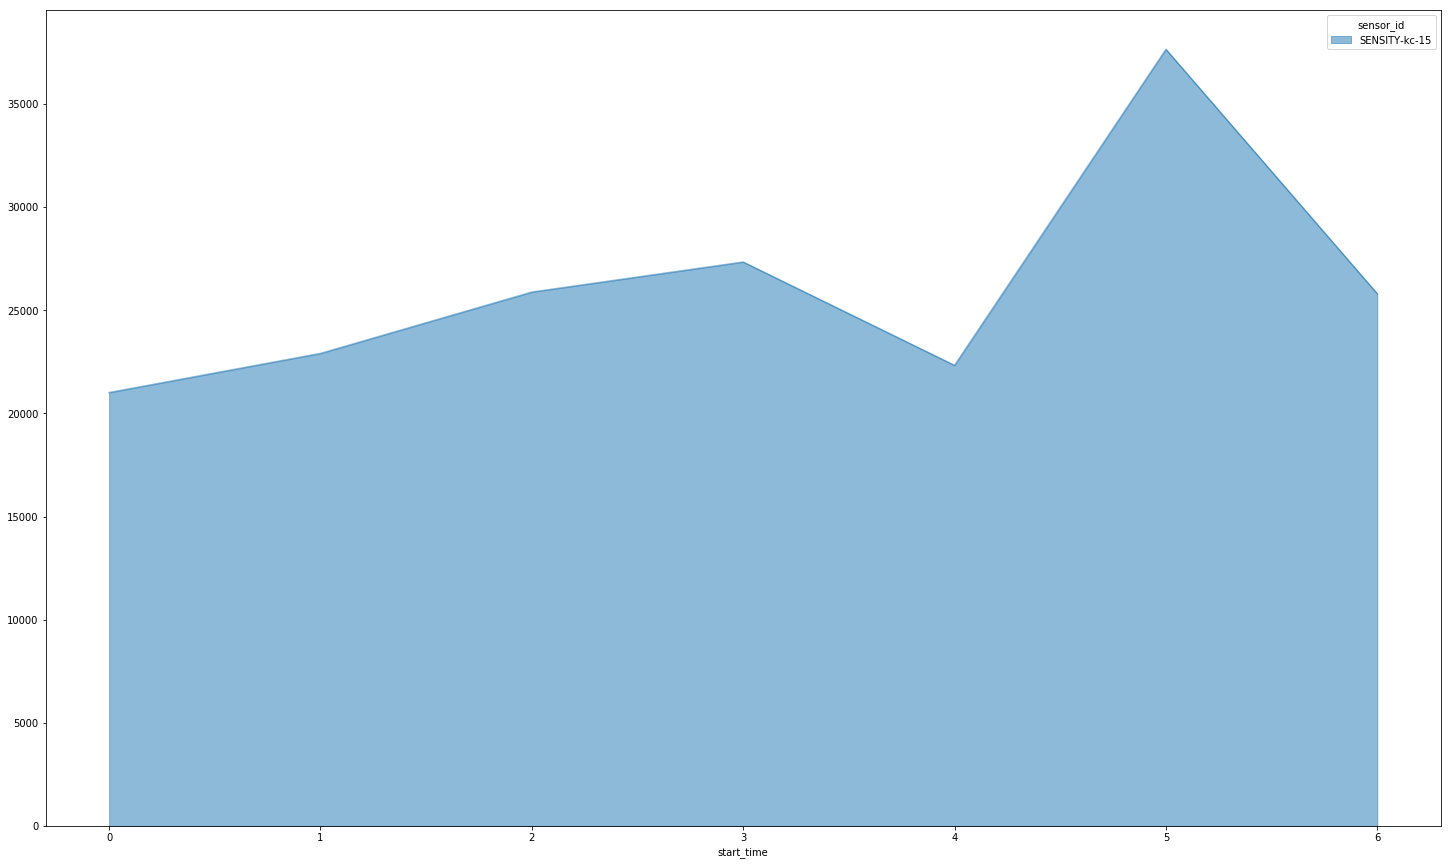

In [66]:
df_sensors_15sensor = df_5min.loc[
                       (df_5min['sensor_id'].isin(['SENSITY-kc-15']))
                      ].groupby(['sensor_id',df_5min.start_time.dt.dayofweek])\
.sum()[['no_of_cars']].add_suffix('_Count').reset_index()
df_pivot_sen_15sensor = df_sensors_15sensor.pivot(index='start_time', columns='sensor_id', values='no_of_cars_Count')
df_pivot_sen_15sensor.fillna(0,inplace=True)
df_pivot_sen_15sensor.plot(kind='area', 
             stacked=False,
             figsize=(25, 15),
             )

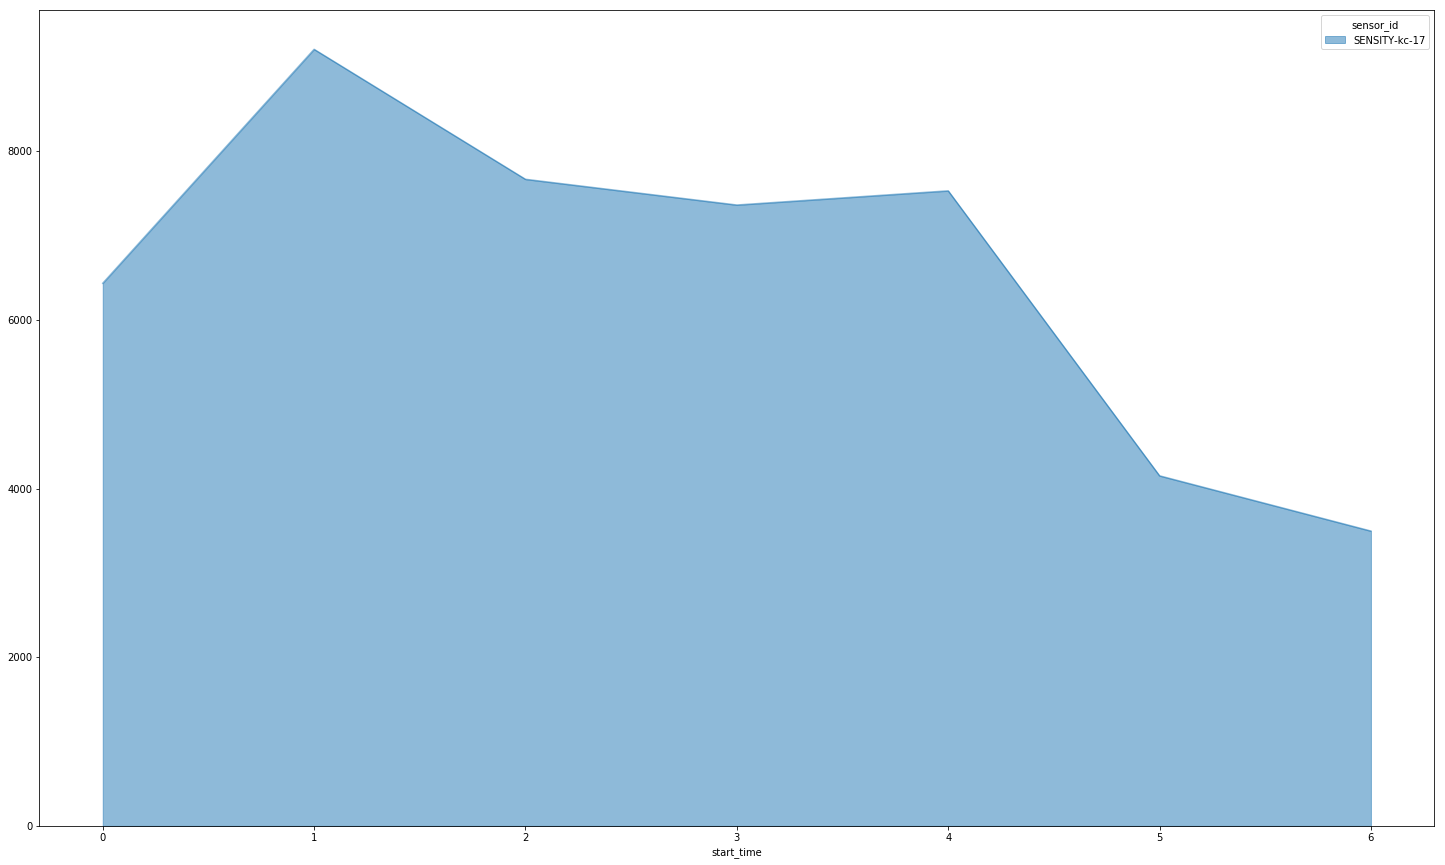

In [67]:
df_sensors_17sensor = df_5min.loc[
                       (df_5min['sensor_id'].isin(['SENSITY-kc-17']))
                      ].groupby(['sensor_id',df_5min.start_time.dt.dayofweek])\
.sum()[['no_of_cars']].add_suffix('_Count').reset_index()
df_pivot_sen_17sensor = df_sensors_17sensor.pivot(index='start_time', columns='sensor_id', values='no_of_cars_Count')
df_pivot_sen_17sensor.fillna(0,inplace=True)
df_pivot_sen_17sensor.plot(kind='area', 
             stacked=False,
             figsize=(25, 15),
             )

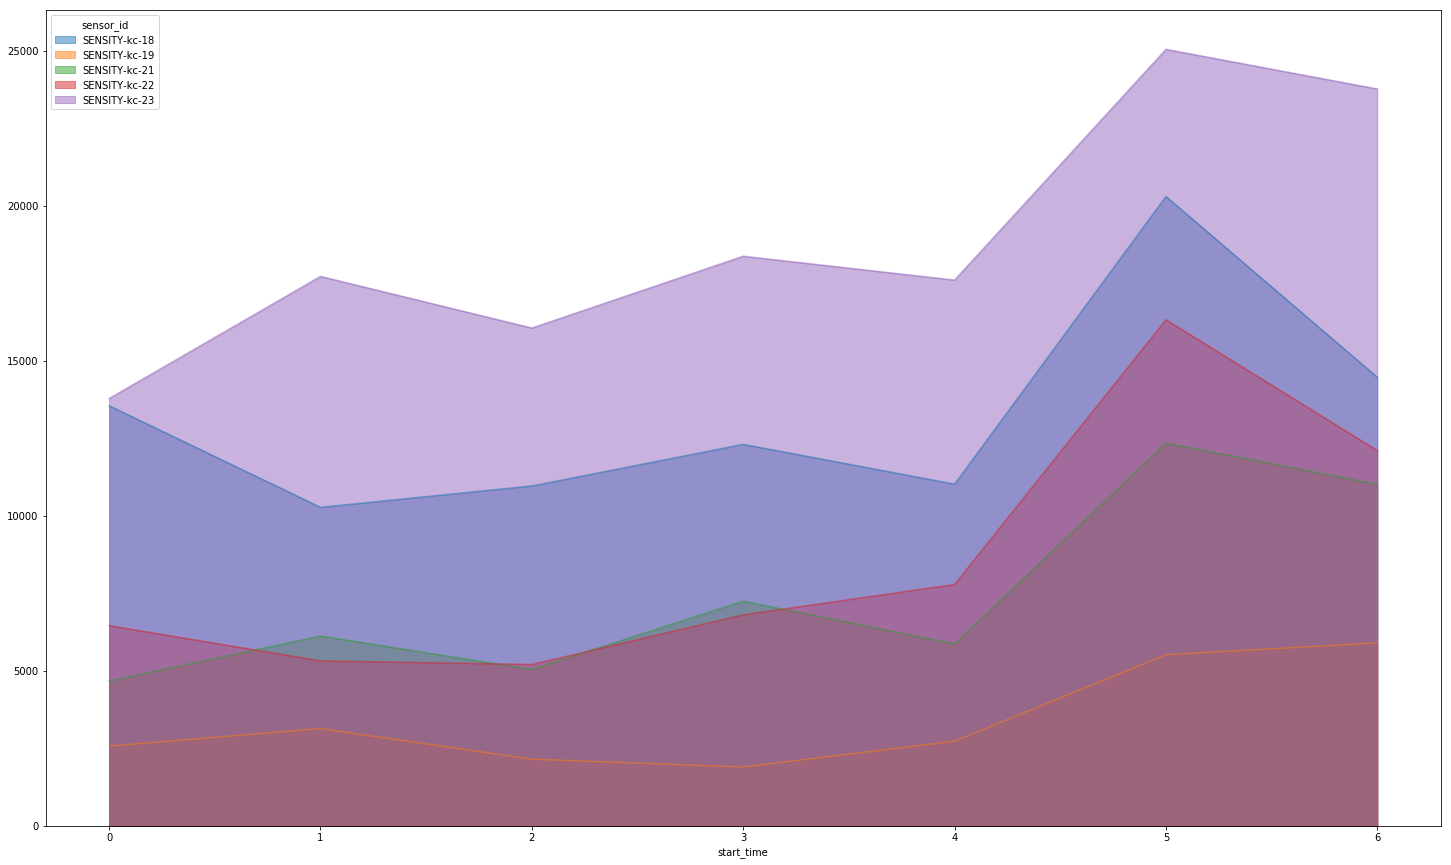

In [68]:
df_sensors_18n23sensor = df_5min.loc[
                       (df_5min['sensor_id'].isin(['SENSITY-kc-18','SENSITY-kc-19','SENSITY-kc-21','SENSITY-kc-22',\
                                                  'SENSITY-kc-23']))
                      ].groupby(['sensor_id',df_5min.start_time.dt.dayofweek])\
.sum()[['no_of_cars']].add_suffix('_Count').reset_index()
df_pivot_sen_18n23sensor = df_sensors_18n23sensor.pivot(index='start_time', columns='sensor_id', values='no_of_cars_Count')
df_pivot_sen_18n23sensor.fillna(0,inplace=True)
df_pivot_sen_18n23sensor.plot(kind='area', 
             stacked=False,
             figsize=(25, 15),
             )

In [182]:
df_tst_5min = df_5min.loc[(df_5min['sensor_id']=='SENSITY-kc-14')  &
                       (df_5min.start_time.dt.date.astype(str) 
                                                                  < '2018-09-10')
                      ]

In [183]:
df_tst_5min.count()

start_time    7592
end_time      7592
sensor_id     7592
no_of_cars    7592
dtype: int64

In [184]:
df_tst_5min= df_tst_5min[['start_time','no_of_cars']]
df_tst_5min = df_tst_5min.set_index('start_time')

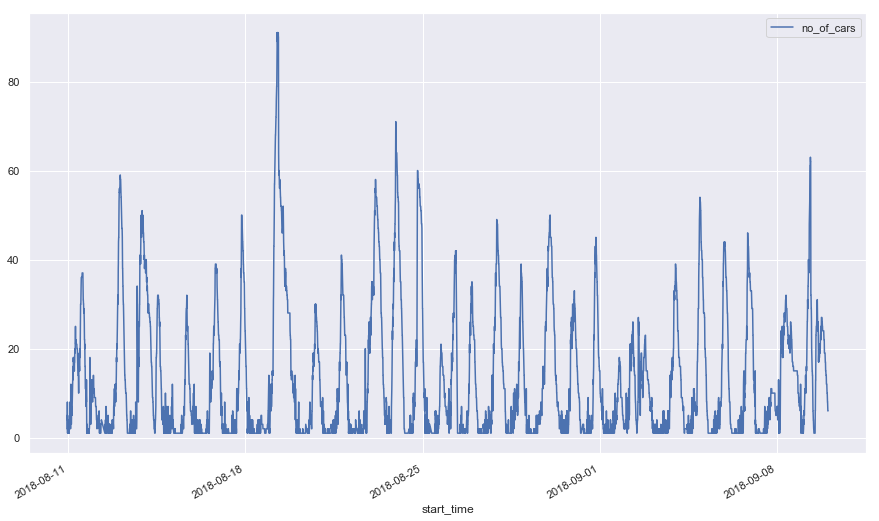

In [185]:
df_tst_5min.plot(figsize=(15,9))

In [172]:
temp_df = df_5min.loc[df_5min['no_of_cars']>25].groupby(['sensor_id']).count()[['no_of_cars']]

In [173]:
temp_df.reset_index(inplace=True)

In [174]:
temp_df =temp_df.sort_values(by=['no_of_cars'],ascending=False)

In [176]:
temp_df.sum()

sensor_id     SENSITY-kc-14SENSITY-kc-5SENSITY-kc-2SENSITY-k...
no_of_cars                                                10249
dtype: object

Text(0,0.5,'Count of Carks Parked')

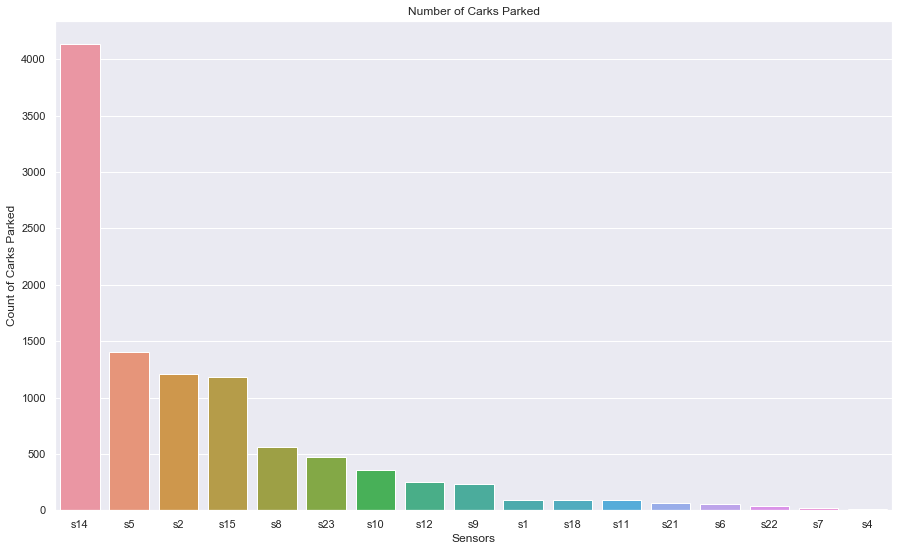

In [177]:
import seaborn as sns
sns.set()
sns.barplot('s'+temp_df['sensor_id'].str.slice(11),
            temp_df['no_of_cars'], data=temp_df)
plt.title("Number of Carks Parked")
plt.xlabel("Sensors")
plt.ylabel("Count of Carks Parked")

In [178]:
loc_df =df_5min.loc[(df_5min['no_of_cars']>25) & (df_5min['sensor_id']=='SENSITY-kc-14')]\
.sort_values(by=['no_of_cars'],ascending=False)

In [179]:
loc_df['weekday'] = loc_df.start_time.dt.weekday_name

In [180]:
loc_df

,start_time,end_time,sensor_id,no_of_cars,weekday
276740,2018-11-03 13:30:00,2018-11-03 13:35:00,SENSITY-kc-14,131,Saturday
276723,2018-11-03 13:25:00,2018-11-03 13:30:00,SENSITY-kc-14,131,Saturday
276706,2018-11-03 13:20:00,2018-11-03 13:25:00,SENSITY-kc-14,131,Saturday
276689,2018-11-03 13:15:00,2018-11-03 13:20:00,SENSITY-kc-14,131,Saturday
276757,2018-11-03 13:35:00,2018-11-03 13:40:00,SENSITY-kc-14,130,Saturday
276774,2018-11-03 13:40:00,2018-11-03 13:45:00,SENSITY-kc-14,130,Saturday
276672,2018-11-03 13:10:00,2018-11-03 13:15:00,SENSITY-kc-14,130,Saturday
276655,2018-11-03 13:05:00,2018-11-03 13:10:00,SENSITY-kc-14,130,Saturday
276573,2018-11-03 12:40:00,2018-11-03 12:45:00,SENSITY-kc-14,128,Saturday
276589,2018-11-03 12:45:00,2018-11-03 12:50:00,SENSITY-kc-14,127,Saturday


In [166]:
loc_df.dtypes

start_time    datetime64[ns]
end_time      datetime64[ns]
sensor_id             object
no_of_cars             int64
weekday               object
dtype: object

In [ ]:
indexedDataset_logScale = np.log(df_tst_5min)
indexedDataset_logScale.plot(figsize=(15,9))

In [ ]:
def test_stationarity(timeseries):
    
    movingAverage = timeseries.rolling(window=50).mean()
    movingSTD = timeseries.rolling(window=50).std()
    
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['no_of_cars'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
test_stationarity(indexedDataset_logScale)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
fig=plt.figure(figsize=(13,8))
ax1=fig.add_subplot(211)
plot_acf(indexedDataset_logScale,lags=50,ax=ax1)

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
fig=plt.figure(figsize=(13,8))
ax1=fig.add_subplot(211)
plot_pacf(indexedDataset_logScale,lags=50,ax=ax1)

In [ ]:
model = ARIMA(indexedDataset_logSale, order=(4,0,0))
results_AR = model.fit(disp=-1)
plt.plot(indexedDataset_logScale, color='green',label='Actual Values')
plt.plot(results_AR.fittedvalues, color='red', label='Predicted Values')
plt.legend(loc='best')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - indexedDataset_logScale['no_of_cars'])**2))
print('Plotting AR model')

In [ ]:
X = indexedDataset_logScale.values
X1= df_tst_5min.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
size1 = int(len(X1) * 0.66)
train1, test1 = X1[0:size1], X1[size1:len(X1)]
print(train.shape)
print(test.shape)

In [ ]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(df_tst_5min, start_p=3, start_q=2,
                           max_p=7, max_q=7, m=1,
                           start_P=0, seasonal=False,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

In [ ]:
stepwise_model.fit(train)
stepwise_model.aic()

In [ ]:
future_forecast = stepwise_model.predict(n_periods=37)

In [ ]:
n = sm.tsa.SARIMAX(indexedDataset_logScale, order=(3,0,0), seasonal_order=(3,1,0,90)).fit(disp=False)
print(n.aic)
j = n.predict(2038,2063)
plt.plot(indexedDataset_logScale.values)
plt.plot(j)

In [ ]:
history = [x for x in train1]
predictions = list()
for t in range(len(test1)):
	model =  ARIMA(history, order=(1,2,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test1[t]
	history.append(obs)
# 	print('predicted=%f, expected=%f' % (yhat, obs))
error = (mean_squared_error(test1, predictions))
print('Test MSE: %.3f' % error)
# plot
plt.plot(test1, color='green',label='Actual Values')
plt.plot(predictions, color='red', label='Predicted Values')
plt.legend(loc='best')
plt.title('Actual vs Predicted Values')
plt.show(block=False)

In [ ]:
import folium
map = folium.Map(location=[39.0974308740626,  -94.583384115077], zoom_start=15)
incidents = folium.map.FeatureGroup()
incidents.add_child(
    folium.Marker(
        [39.08886983743, -94.5838369624951],popup='Sensor  1'
    )
)
incidents.add_child(
    folium.Marker(
        [39.0895257143255, -94.5836298337034],popup='Sensor 3'
    )
)
# 4
incidents.add_child(
    folium.Marker(
        [39.089630718015, -94.5837829389517],popup='Sensor 4'
    )
)
#5
incidents.add_child(
    folium.Marker(
        [39.0903414514362, -94.5839528980185],popup='Sensor 5'
    )
)
#6
incidents.add_child(
    folium.Marker(
        [39.0913366391533, -94.5835473387081],popup='Sensor 6'
    )
)
#7
incidents.add_child(
    folium.Marker(
        [39.0914067545037, -94.5836952432815],popup='Sensor 7'
    )
)
# 8
incidents.add_child(
    folium.Marker(
        [39.0929265513351, -94.583473897204],popup='Sensor 8'
    )
)
# 9
incidents.add_child(
    folium.Marker(
        [39.0925714196609, -94.5836462364435], popup='Sensor 9'
    )
)
incidents.add_child(
    folium.Marker(
        [39.0935955318767, -94.5834250020739], popup='Sensor 10'
    )
)
incidents.add_child(
    folium.Marker(
        [39.0936194911347, -94.5835815821614], popup='Sensor 11'
    )
)
incidents.add_child(
    folium.Marker(
        [39.0953130727494, -94.5835150826366], popup='Sensor 12'
    )
)
incidents.add_child(
    folium.Marker(
        [39.0974308740626, -94.583384115077], popup='Sensor 14'
    )
)
incidents.add_child(
    folium.Marker(
        [39.1008767383508, -94.5833650989779], popup='Sensor 15'
    )
)
incidents.add_child(
    folium.Marker(
        [39.1041953330822, -94.5830621136463], popup='Sensor 17'
    )
)
incidents.add_child(
    folium.Marker(
        [39.108178202775, -94.5838370828335], popup='Sensor 18'
    )
)
incidents.add_child(
    folium.Marker(
        [39.1084723889037, -94.582585360964], popup='Sensor 19'
    )
)

incidents.add_child(
    folium.Marker(
        [39.1090879195403, -94.5805962543708], popup='Sensor 21'
    )
)
incidents.add_child(
    folium.Marker(
        [39.1100825602005, -94.5809499378285], popup='Sensor 22'
    )
)
incidents.add_child(
    folium.Marker(
        [39.1099732781504, -94.5835935582531], popup='Sensor 23'
    )
)
map.add_child(incidents)
map.save('main_street_sensors.html')

In [ ]:
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random
# contrived dataset with dependency
data = list()
for i in range(100):
    v1 = i + random()
    v2 = v1 + random()
    row = [v1, v2]
    data.append(row)
    data_exog = [x + random() for x in range(100)]
# fit model
print(data)
# model = VAR(data)
# model_fit = model.fit()
# # make prediction
# yhat = model_fit.forecast(model_fit.y, steps=1)
# print('it is',yhat)

model = VARMAX(data, exog=data_exog, order=(9, 9))
model_fit = model.fit(disp=False)
# make prediction
data_exog2 = [[100]]
yhat = model_fit.forecast(exog=data_exog2)
print(yhat)
data[77][1]